In [1]:
import cv2
import matplotlib.pyplot as plt
from ipcv import cvlib

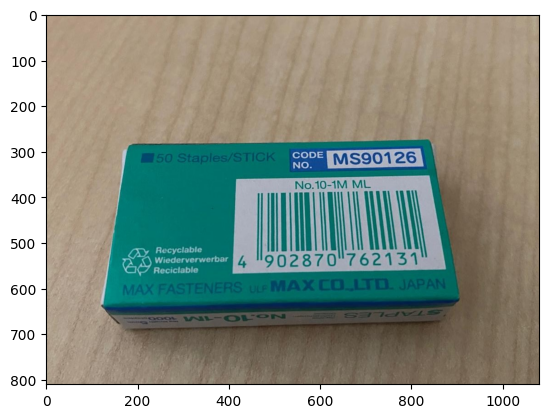

In [2]:
# path = 'resources/barcode/barcode310.jpg'
path = '../resources/barcode/barcode500.jpg'
# path = 'resources/barcode/barcode10.png'
image = cvlib.load_image(path)
plt.imshow(image, cmap='gray')

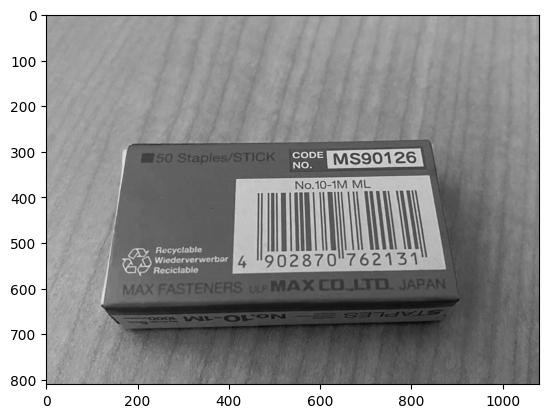

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

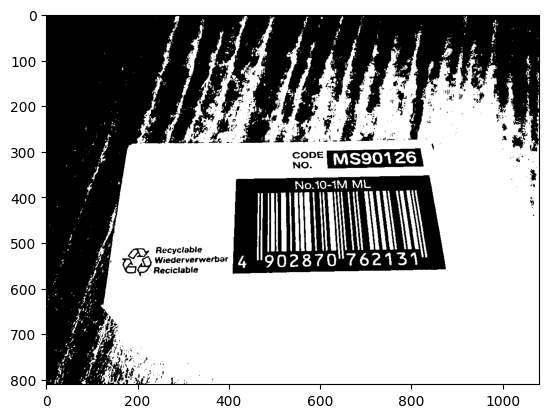

In [4]:
thresh = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(thresh, cmap='gray')

## Angle adjustment

In [5]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [6]:
import numpy as np
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
print(angle)

if angle < -45:
	angle = -(90 + angle)
# otherwise, just take the inverse of the angle to make
# it positive
else:
	angle = -angle

print(angle)

# rotate the image to deskew it
# (h, w) = image.shape[:2]
# center = (w // 2, h // 2)
# M = cv2.getRotationMatrix2D(center, angle, 1.0)
# rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
# # draw the correction angle on the image so we can validate it
# cv2.putText(rotated, "Angle: {:.2f} degrees".format(angle),
# 	(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
# # show the output image
# print("[INFO] angle: {:.3f}".format(angle))
#
# plt.imshow(rotated, cmap='gray')

90.0
-90.0


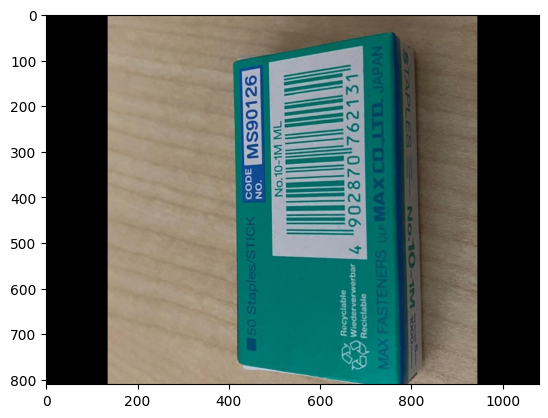

In [7]:
image2 = rotate_image(image, 90)
plt.imshow(image2, cmap='gray')

In [8]:
# rotate the image to deskew it
(h, w) = image.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(image, M, (w, h),
	flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

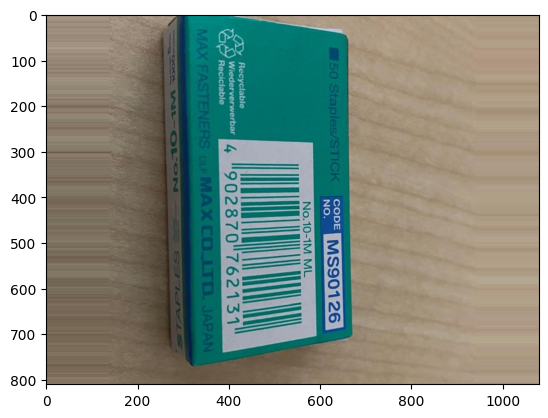

In [9]:
plt.imshow(rotated, cmap='gray')

In [10]:
# draw the correction angle on the image so we can validate it
cv2.putText(rotated, "Angle: {:.2f} degrees".format(angle),
	(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

array([[[165, 148, 132],
        [165, 148, 132],
        [165, 148, 132],
        ...,
        [173, 151, 128],
        [173, 151, 128],
        [173, 151, 128]],

       [[163, 146, 130],
        [163, 146, 130],
        [163, 146, 130],
        ...,
        [173, 153, 129],
        [173, 153, 129],
        [173, 153, 129]],

       [[170, 153, 137],
        [170, 153, 137],
        [170, 153, 137],
        ...,
        [175, 155, 131],
        [175, 155, 131],
        [175, 155, 131]],

       ...,

       [[134, 119, 100],
        [134, 119, 100],
        [134, 119, 100],
        ...,
        [171, 153, 133],
        [171, 153, 133],
        [171, 153, 133]],

       [[135, 120, 101],
        [135, 120, 101],
        [135, 120, 101],
        ...,
        [164, 146, 126],
        [164, 146, 126],
        [164, 146, 126]],

       [[143, 128, 109],
        [143, 128, 109],
        [143, 128, 109],
        ...,
        [165, 147, 127],
        [165, 147, 127],
        [165, 147, 127]]

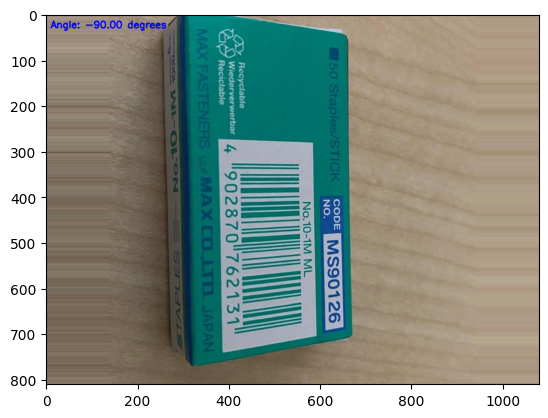

In [11]:
plt.imshow(rotated, cmap='gray')

In [12]:
def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]
        print('cv=2')

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]
        print('cv=3')

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
                         "otherwise OpenCV changed their cv2.findContours return "
                         "signature yet again. Refer to OpenCV's documentation "
                         "in that case"))

    # return the actual contours array
    return cnts

In [13]:
# find the largest contour in the threshold image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# print(len(c))

# draw the shape of the contour on the output image, compute the bounding box, and display the number of points in the contour
output = image.copy()
cv2.drawContours(output, [c], -1, (0, 255, 0), 3)
(x, y, w, h) = cv2.boundingRect(c)
text = "original, num_pts={}".format(len(c))
cv2.putText(output, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# show the original contour image
print("[INFO] {}".format(text))

cv=2
[INFO] original, num_pts=7004


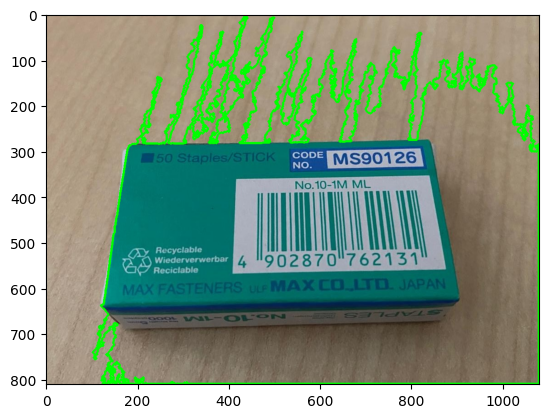

In [14]:
plt.imshow(output, cmap='gray')

In [15]:
import numpy as np

# to demonstrate the impact of contour approximation, let's loop over a number of epsilon sizes.
# linespace generates 10 evenly spaced numbers between 0.001 to 0.05.
for eps in np.linspace(0.001, 0.05, 10):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, eps * peri, True)
    # draw the approximated contour on the image
    output = image.copy()
    cv2.drawContours(output, [approx], -1, (0, 255, 0), 3)
    text = "eps={:.4f}, num_pts={}".format(eps, len(approx))
    cv2.putText(output, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX,
                0.9, (0, 255, 0), 2)
    # show the approximated contour image
    print("[INFO] {}".format(text))

[INFO] eps=0.0010, num_pts=92
[INFO] eps=0.0064, num_pts=16
[INFO] eps=0.0119, num_pts=13
[INFO] eps=0.0173, num_pts=5
[INFO] eps=0.0228, num_pts=4
[INFO] eps=0.0282, num_pts=3
[INFO] eps=0.0337, num_pts=3
[INFO] eps=0.0391, num_pts=3
[INFO] eps=0.0446, num_pts=3
[INFO] eps=0.0500, num_pts=2


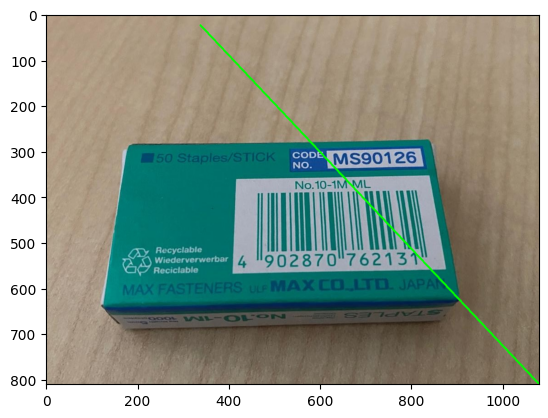

In [16]:
plt.imshow(output, cmap='gray')